##### Copyright 2024 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Working with Charts, Graphs, and Slide Decks

Gemini models are powerful multimodal LLMs that can process both text and image inputs.

This notebook shows how Gemini 1.5 Flash model is capable of extracting data from various images.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Working_with_Charts_Graphs_and_Slide_Decks.ipynb"><img src = "../images/colab_logo_32px.png"/>Run in Google Colab</a>
  </td>
</table>

In [2]:
!pip install -U -q "google-generativeai>=0.7.2"

In [3]:
import os
import time
from glob import glob

import google.generativeai as genai
from PIL import Image
from IPython.display import Markdown, display

## Configure your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) for an example.


In [4]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)

## Setup
You will be using images from [Priyanka Vergadia's](https://github.com/priyankavergadia) [GCPSketchnote](https://github.com/priyankavergadia/GCPSketchnote) repository. These pages contain many details that should provide a good benchmark for Gemini's capabilities.

These images are on [Creative Commons Attribution 4.0 International Public License](https://github.com/priyankavergadia/GCPSketchnote/tree/main?tab=License-1-ov-file).

In [5]:
! git clone https://github.com/priyankavergadia/GCPSketchnote.git

Cloning into 'GCPSketchnote'...
remote: Enumerating objects: 311, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 311 (delta 7), reused 45 (delta 7), pack-reused 250 (from 1)
Receiving objects: 100% (311/311), 117.09 MiB | 12.72 MiB/s, done.
Resolving deltas: 100% (104/104), done.
Updating files: 100% (89/89), done.


In [6]:
images_with_duplicates = glob("/content/GCPSketchnote/images/*")

# Removing duplicate images with different extensions
images = []
encountered = set()
for path in images_with_duplicates:
  path_without_extension, extension = os.path.splitext(path)
  if path_without_extension not in encountered and extension != ".pdf":
    images.append(path)
    encountered.add(path_without_extension)

In [7]:
len(images)

72

## Interpreting a single chart


In [8]:
chart_path_gif = "chart.gif"
!curl https://storage.googleapis.com/gweb-uniblog-publish-prod/original_images/gemini_final_text_table_amendment_13_12_23.gif > $chart_path_gif

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  129k  100  129k    0     0   397k      0 --:--:-- --:--:-- --:--:--  397k


The image needs to be transformed into a `.jpg`, since `.gif` is not supported by Gemini API at the moment.

In [9]:
chart_path_jpg = "chart.jpg"
image = Image.open(chart_path_gif)
image = image.convert('RGB')
image.save(chart_path_jpg)

Now, you will define helper functions for shrinking the image and querying the model with images.

**NOTE**: In this example you will be using Pillow library to load images, but using `Image` from `IPython.display`, or using dictionary with `mime_type` and data fields will also work.

In [10]:
# Make images fit better on screen and decrease data used for requests
def shrink_image(image: Image, ratio = 2):
  width, height = image.size
  return image.convert('RGB').resize((width//ratio, height//ratio))

In [11]:
def generate_content_from_image(prompt, image_paths):
  model = genai.GenerativeModel('models/gemini-1.5-flash-latest')
  response = model.generate_content(
    contents=[prompt] + [shrink_image(Image.open(image_path)) for image_path in image_paths],
    request_options={"timeout": 600}
  )
  return response.text

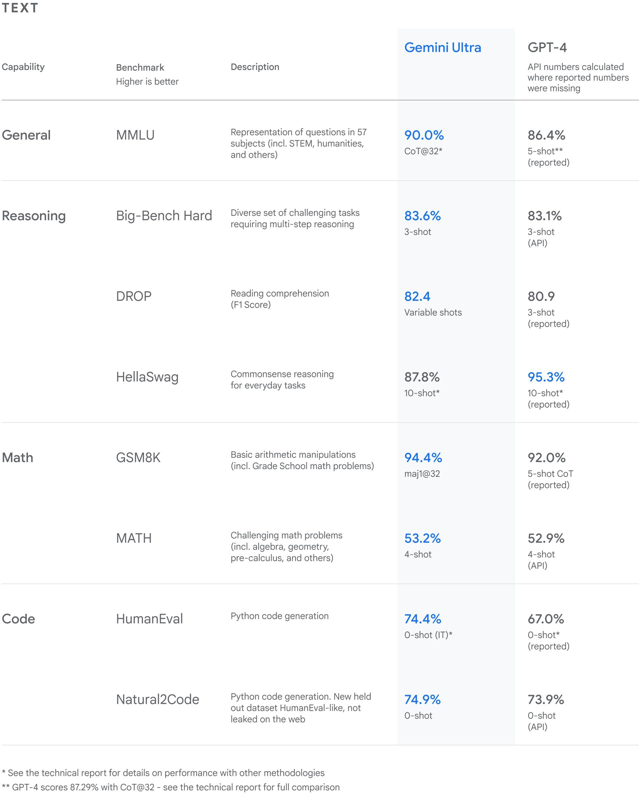

In [12]:
shrink_image(Image.open(chart_path_jpg), 3)

Now, let's see how the LLM can handle the following query.

In [13]:
prompt = """You are a tool that interprets tables. Which model (Gemini Ultra or GPT-4) is better in the 'Math' category in MATH benchmark?"""
Markdown(generate_content_from_image(prompt, [chart_path_jpg]))

According to the provided table, Gemini Ultra scores 94.4% on GSM8K benchmark in the 'Math' category, while GPT-4 scores 92.0%. Therefore, Gemini Ultra is better in the 'Math' category in MATH benchmark.

## Extracting information from a single slide
You will use the model to extract information from a single slide. In this case graph describing pub/sub. It is not a complicated usecase, however it will showcase, how you can call the model.

You need to download an example chart.


In [14]:
image_path = "/content/GCPSketchnote/images/pubsub.jpg"

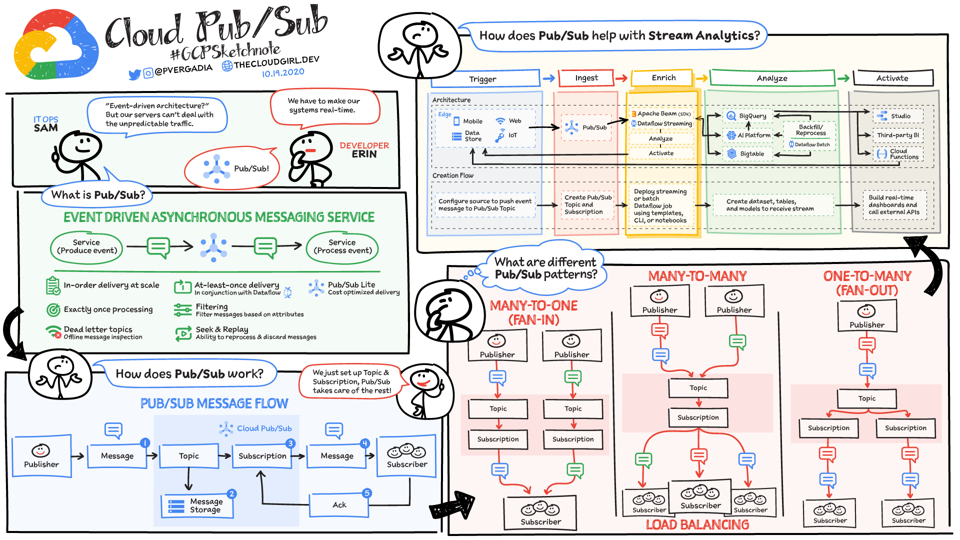

In [15]:
shrink_image(Image.open(image_path))

Start with something simple:

In [16]:
prompt = "Describe the image in 5 sentences."
response = generate_content_from_image(prompt, [image_path])
Markdown(response)

The image is a diagram explaining the concept of Pub/Sub, a cloud messaging service. It shows the different use cases of Pub/Sub and how it can be used for real-time data processing, stream analytics, and event-driven architectures. The diagram also highlights the different patterns of Pub/Sub like Many-to-one, Many-to-many, and One-to-many. In the middle, a simplified message flow is presented, illustrating the steps involved in publishing and subscribing to messages. The diagram is accompanied by hand-drawn illustrations and humorous captions, making it engaging and informative.  


You can also use it to extract information from specific parts of the image:

In [17]:
prompt = "Explain the diffrent pub sub patters using the image. Ignore the rest."
response = generate_content_from_image(prompt, [image_path])
Markdown(response)

The image shows three different Pub/Sub patterns:

* **Many-to-One (Fan-In):** In this pattern, multiple publishers send messages to a single topic. A single subscriber listens to this topic and consumes all the messages.
* **Many-to-Many:** This pattern allows multiple publishers to send messages to a single topic and multiple subscribers can consume messages from that topic. It is useful for load balancing and ensuring that messages are distributed across multiple consumers.
* **One-to-Many (Fan-Out):**  This pattern has a single publisher sending messages to a topic, and multiple subscribers are listening to that topic.  This pattern is used to distribute messages to a large number of consumers.

## Slide Decks
While most models can receive only a handful images at once, The Gemini 1.5 Flash model is able to receive up to 3,600 images in a single request. This means that most slide decks can be passed without any splitting to the model.

In this case you will use the LLM to create a set of questions that check the knowledge of GCP products:

In [18]:
prompt = "Your job is to create a set of questions to check knowledge of various gcp products. Write for each image the topic and example question."
response = generate_content_from_image(prompt, images[:4])
Markdown(response)

## Image 1: BeyondCorp & BeyondCorp Enterprise

**Topic:** BeyondCorp and BeyondCorp Enterprise

**Example Question:** What is the difference between BeyondCorp and BeyondCorp Enterprise? 

## Image 2: Datastream 

**Topic:** Datastream

**Example Question:** What are the different connectivity options available for Datastream? 

## Image 3: Dataproc

**Topic:** Dataproc

**Example Question:** How does Dataproc disaggregate storage and compute? 

## Image 4: Introduction to Cloud Networking

**Topic:** Google Cloud Network Infrastructure

**Example Question:** What are the different networking services offered by Google Cloud? 


# Summary

The Gemini API's great capabilities in processing images such as charts, graphs, and slide decks highlights the power of multimodal LLMs. Thanks to the model's ability to read and understand these visual elements, everyone can unlock great ideas, simplify tasks, and save valuable time.

Imagine the impact of leveraging Gemini API to implement AI solutions that describe surroundings for the disabled community, making technology more inclusive and accessible to all.

This is just one of the exciting possibilities. Now, it's your turn to explore Gemini 1.5 Flash further!